In [1]:
!pip install datasets umap-learn
import pandas as pd, os
from tqdm import tqdm  
import numpy as np
import datasets 


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 474.6/474.6 kB 1.7 MB/s eta 0:00:00
     ---------------------------------------- 88.2/88.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------ 323.6/323.6 kB 501.4 kB/s eta 0:00:00
     ------------------------------------ 110.5/110.5 kB 533.4 kB/s eta 0:00:00
     ------------------------------------ 132.9/132.9 kB 490.5 kB/s eta 0:00:00
     ---------------------------------------- 21.5/21.5 MB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 61.7/61.7 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 27.7/27.7 MB 1.1 MB/s eta 0:00:00


c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#Pandas Df
We will read train text into a Pandas df.

In [2]:
from datasets import load_dataset

dataset = load_dataset("SetFit/bbc-news")

train_text_df = pd.DataFrame({'text': dataset['train']['text']})
train_text_df.head()

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 52.66it/s]


Dataset json downloaded and prepared to C:/Users/askar/.cache/huggingface/datasets/SetFit___json/SetFit--bbc-news-dbeb222bfdd4d6ed/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 52.66it/s]


,text
0,wales want rugby league training wales could f...
1,china aviation seeks rescue deal scandal-hit j...
2,rock band u2 break ticket record u2 have smash...
3,markets signal brazilian recovery the brazilia...
4,tough rules for ringtone sellers firms that fl...


#Tfidf
We will use Tfidf to convert each text into a embedding vector of length 25,000.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', binary=True, max_features=25_000)
text_embeddings = tfidf.fit_transform( train_text_df['text'] ).toarray()

# UMAP
We will use UMAP (Uniform Manifold Approximation and Projection for Dimension Reduction) to reduce embedding vectors to two dimensions

In [4]:
from umap import UMAP
umap = UMAP()
embed_2d = umap.fit_transform(text_embeddings)

c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\askar\AppData\Local\Programs\Python\Python39\

# KMeans
We will use KMeans to find clusters of essays. These are the essay topics!

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(embed_2d)
train_text_df['cluster'] = kmeans.labels_

c:\Users\askar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Display Topics
We will display the result of UMAP which reduced text to two dimension.

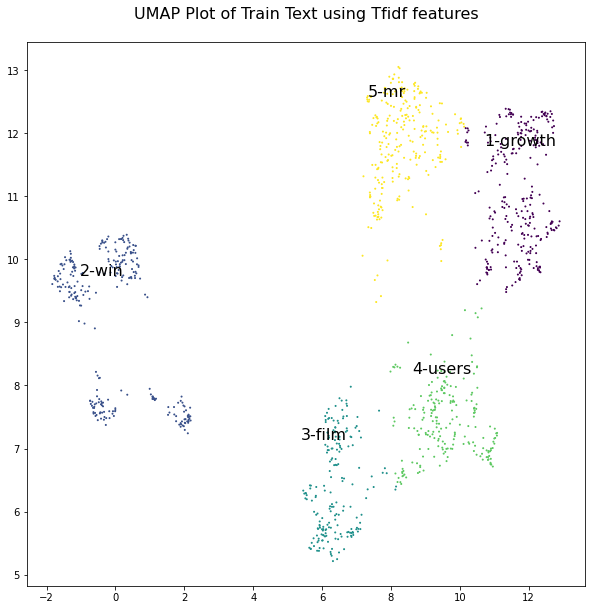

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt

centers = kmeans.cluster_centers_

plt.figure(figsize=(10,10))
plt.scatter(embed_2d[:,0], embed_2d[:,1], s=1, c=kmeans.labels_)
plt.title('UMAP Plot of Train Text using Tfidf features\n',size=16)

for k in range(len(centers)):
    mm = np.mean( text_embeddings[train_text_df.cluster.values==k],axis=0 )
    ii = np.argmax(mm)
    top_word = list(tfidf.vocabulary_.keys())[list(tfidf.vocabulary_.values()).index(ii)]
    plt.text(centers[k,0]-1,centers[k,1]+0.75,f'{k+1}-{top_word}',size=16)

plt.show()
plt.savefig('clusters.png')

# Display Example Text
We will display three example text from each topic. And we will display the five most important words from each topic.

In [7]:
for k in range(5):
    mm = np.mean( text_embeddings[train_text_df.cluster.values==k],axis=0 )
    ii = ( np.argsort(mm)[-5:][::-1] )
    top_words = [list(tfidf.vocabulary_.keys())[list(tfidf.vocabulary_.values()).index(i)] for i in ii]
    print('#'*25)
    print(f'### Topic {k+1}')
    print('### Top 5 Words',top_words)
    print('#'*25)
    tmp = train_text_df.loc[train_text_df.cluster==k].sample(3, random_state=123)
    for j in range(3):
        txt = tmp.iloc[j,0]
        print('-'*10,f'Example {j+1}','-'*10)
        print(txt,'\n')

#########################
### Topic 1
### Top 5 Words ['growth', 'market', 'company', 'economy', 'said']
#########################
---------- Example 1 ----------
eu ministers to mull jet fuel tax european union finance ministers are meeting on thursday in brussels  where they are to discuss a controversial jet fuel tax.  a levy on jet fuel has been suggested as a way to raise funds to finance aid for the world s poorest nations. airlines and aviation bodies have reacted strongly against the plans  saying they would hurt companies at a time when earnings are under pressure. the eu said a tax would only be passed after full consultation with airlines. it was keen to point out earlier this week that any new tax on jet fuel should not hurt the  competitiveness of the airlines . ministers will also be discussing reforms to regulations governing european public spending.  global leaders have focused attention on poverty reduction and development at recent meetings of the g7 group and world 